In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-dataset/diabetes.csv


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report,confusion_matrix,auc,accuracy_score,precision_recall_curve,roc_curve

from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
import scipy.stats as stats

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input , Dense , Dropout, BatchNormalization 
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [3]:
df = pd.read_csv("/kaggle/input/diabetes-dataset/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Data Preprocessing and EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### Checking Normal Distributions 

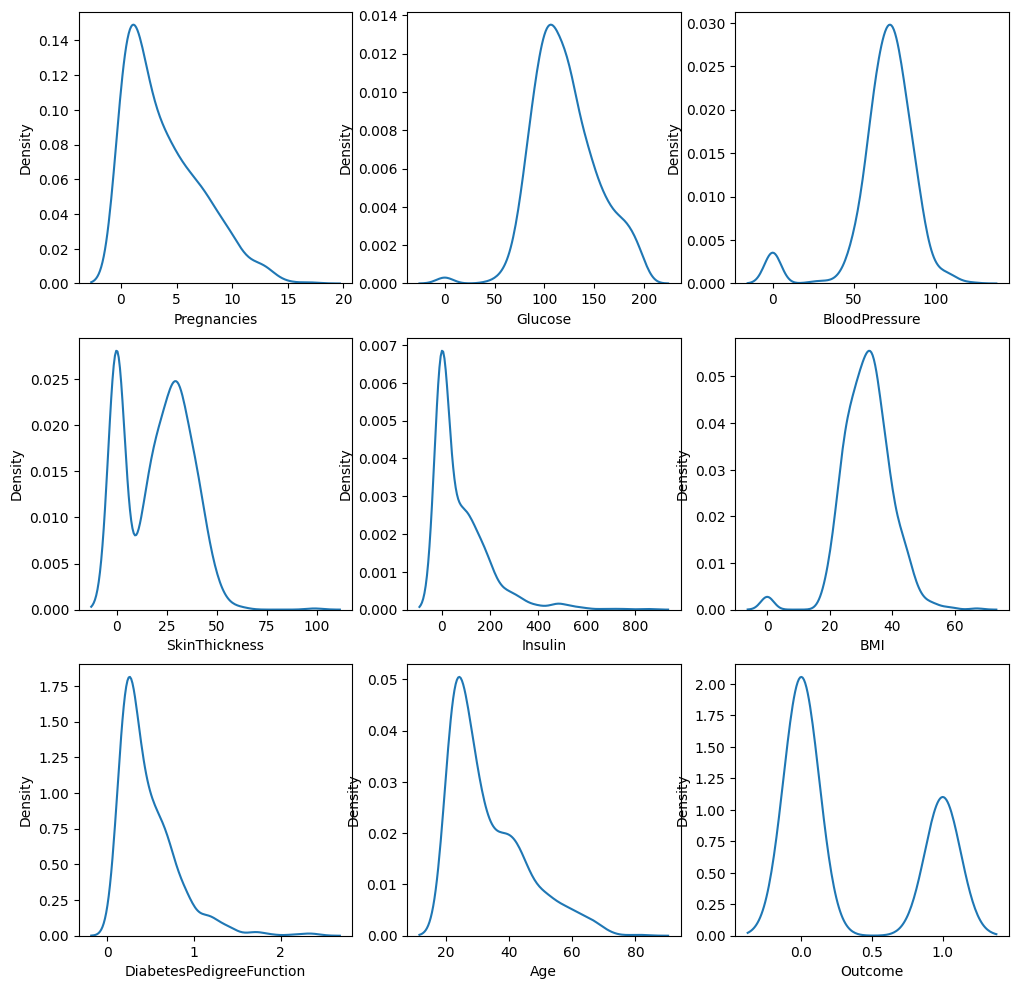

In [6]:
plt.figure(figsize=(12,12))
i=1
for col in df.columns:
    plt.subplot(3,3,i)
    sns.kdeplot(df[col])
    i+=1

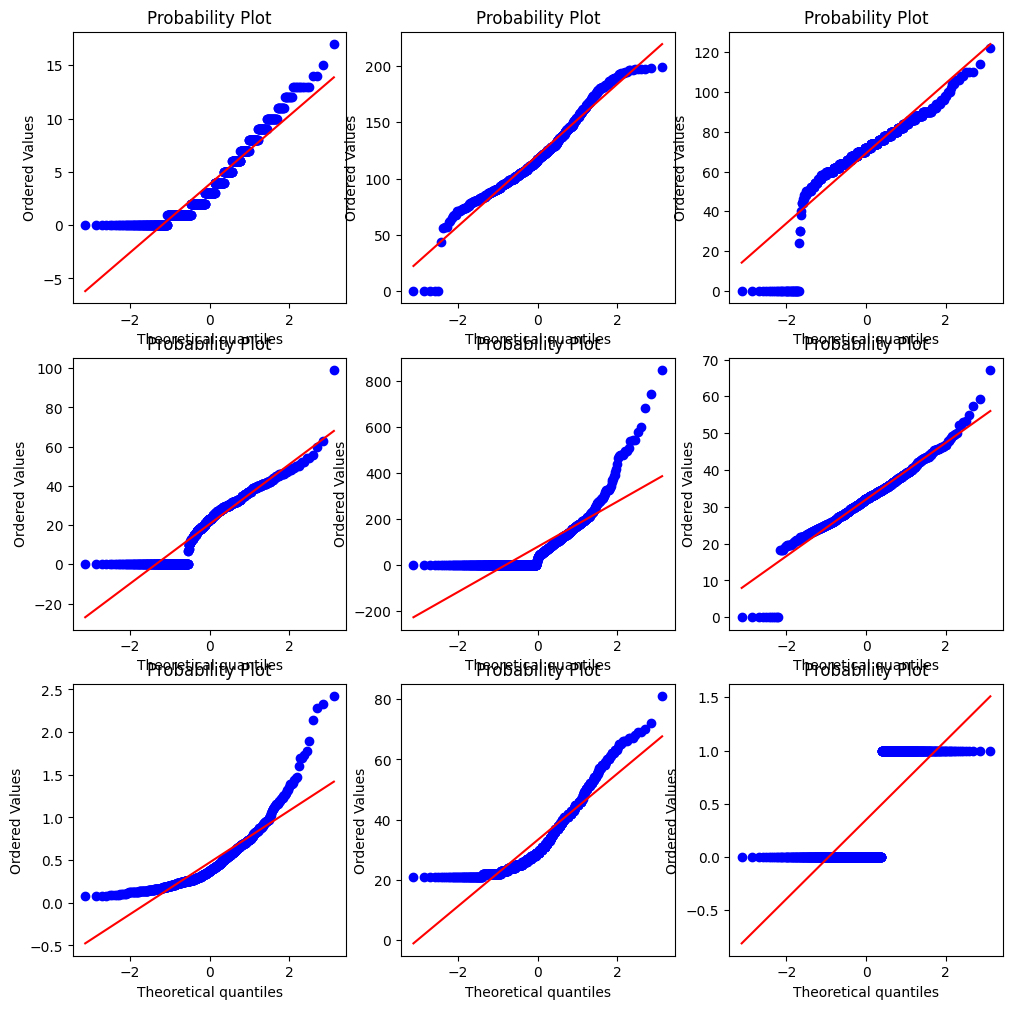

In [7]:
plt.figure(figsize=(12,12))
i=1
for col in df.columns:
    plt.subplot(3,3,i)
    stats.probplot(df[col],dist='norm',plot=plt)
    i+=1

## Outlier Detection

In [8]:
# Outliers are nothing but the point which are far away from observed value
# First we have to detect outliers and then we can handle outliers. Without handling outlier our model
# will not perform betterso we have to handle that outliers in the data

# Outliers Detection Method
# 1. Z-Score Method
# 2. IQR Method
# 3. Percentile Method

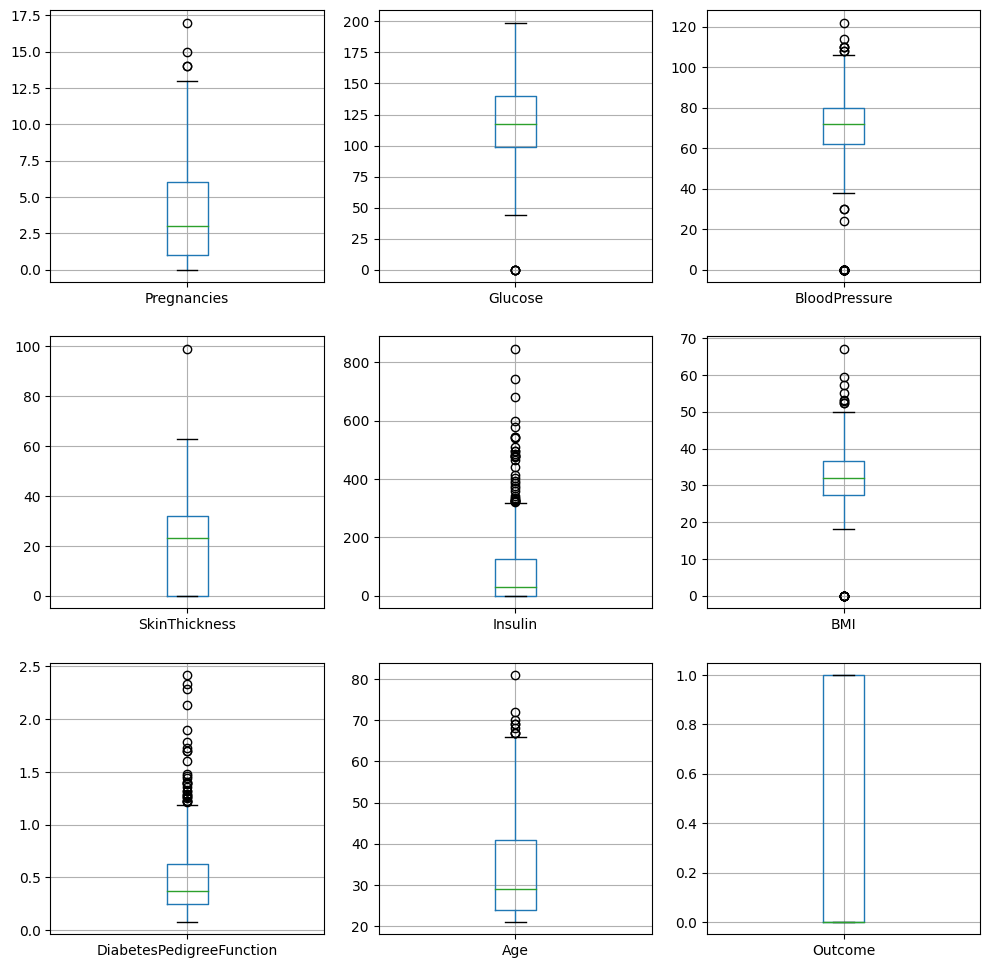

In [9]:
plt.figure(figsize=(12,12))
i=1
for col in df.columns:
    plt.subplot(3,3,i)
    df[[col]].boxplot()
    i+=1

In [10]:
## Checking Skewness in each features
df.skew()

Pregnancies                 0.901674
Glucose                     0.173754
BloodPressure              -1.843608
SkinThickness               0.109372
Insulin                     2.272251
BMI                        -0.428982
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64

## Outlier Handling

#### Z- Score = If the features are normally distributed
#### IQR Method = If the features are skewed ( positive or negative)

In [11]:
for col in df.iloc[:,:-1]:
    ## Z-Score Method
    if df[col].skew()<0.5 and df[col].skew()>-0.5:
        up_limit = df[col].mean() + 3 * df[col].std()
        lw_limit = df[col].mean() - 3 * df[col].std()
        
        df[col] = np.where(df[col]>up_limit, up_limit,
                          np.where(df[col]<lw_limit , lw_limit , df[col]))
        
    elif df[col].skew()>0.5 or df[col].skew()<-0.5:
        q3 = df[col].quantile(0.75)
        q1 = df[col].quantile(0.25)
        IQR = q3-q1
        up_limit = q3 + 1.5 * IQR
        lw_limit = q1 - 1.5 * IQR
        
        df[col] = np.where(df[col]>up_limit, up_limit,
                          np.where(df[col]<lw_limit , lw_limit , df[col]))

## After Handling Outliers 

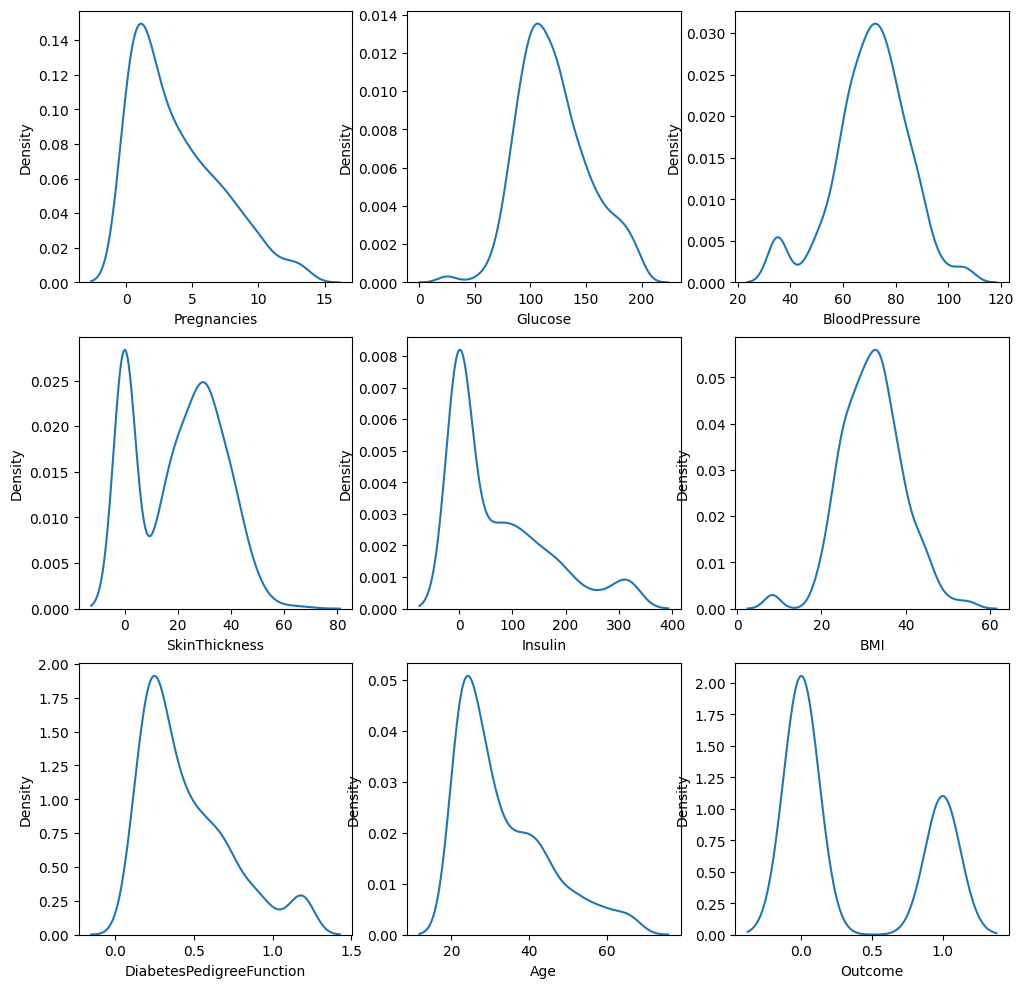

In [12]:
## Checking Normal Distributions of the graph of each features
plt.figure(figsize=(12,12))
i=1
for col in df.columns:
    plt.subplot(3,3,i)
    sns.kdeplot(df[col])
    i+=1

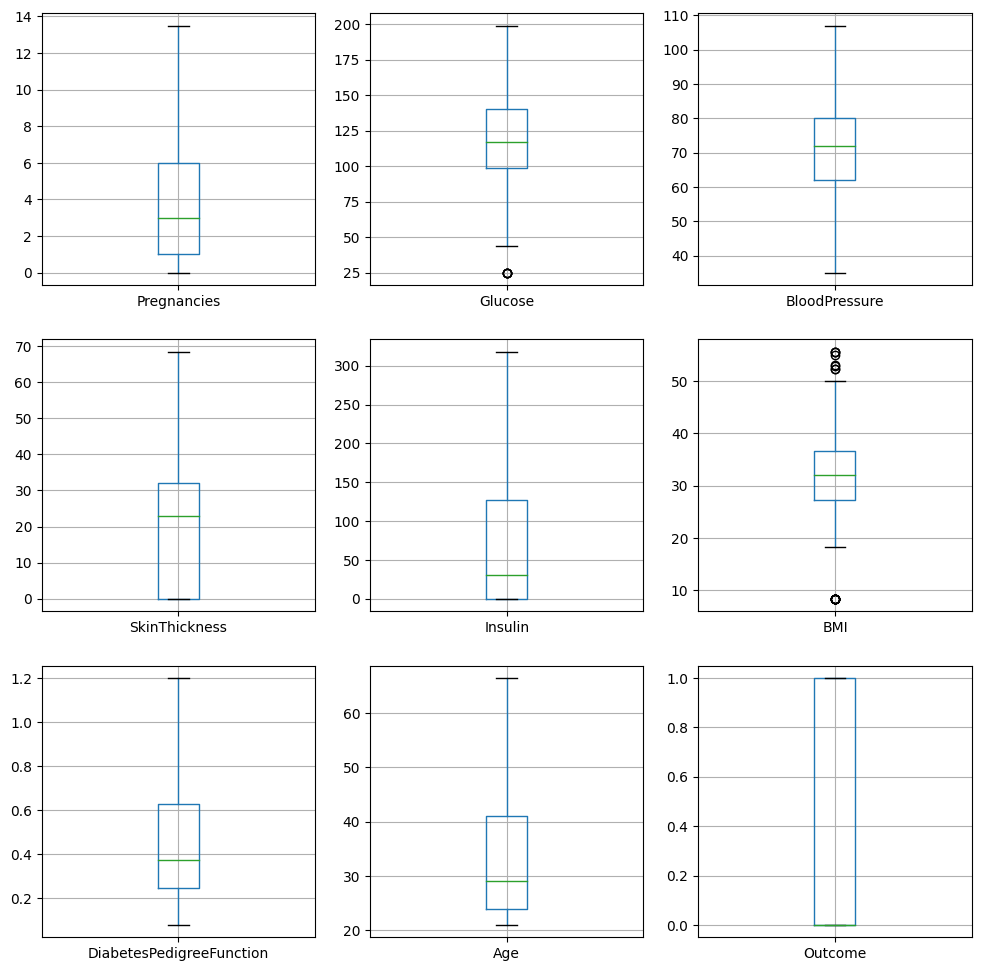

In [13]:
## Checking outliers in the graph
plt.figure(figsize=(12,12))
i=1
for col in df.columns:
    plt.subplot(3,3,i)
    df[[col]].boxplot()
    i+=1

In [14]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,1


## Split the data for training and testing purpose

In [15]:
x = df.drop('Outcome',axis=1)
y = df['Outcome']

In [16]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 8)
(154, 8)
(614,)
(154,)


In [17]:
x_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
442,4.0,117.0,64.0,27.0,120.0,33.2,0.230,24.0
657,1.0,120.0,80.0,48.0,200.0,38.9,1.162,41.0
166,3.0,148.0,66.0,25.0,0.0,32.5,0.256,22.0
634,10.0,92.0,62.0,0.0,0.0,25.9,0.167,31.0
483,0.0,84.0,82.0,31.0,125.0,38.2,0.233,23.0
...,...,...,...,...,...,...,...,...
31,3.0,158.0,76.0,36.0,245.0,31.6,0.851,28.0
478,8.0,126.0,74.0,38.0,75.0,25.9,0.162,39.0
307,0.0,137.0,68.0,14.0,148.0,24.8,0.143,21.0
332,1.0,180.0,35.0,0.0,0.0,43.3,0.282,41.0


In [18]:
y_train

442    0
657    0
166    0
634    0
483    0
      ..
31     1
478    0
307    0
332    1
44     0
Name: Outcome, Length: 614, dtype: int64

In [19]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

## Using LogisticRegression 

In [20]:
lg_model = LogisticRegression()
lg_model.fit(x_train, y_train)
y_pred = lg_model.predict(x_test)
print("-----Model Evaluation on Test Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
print()
print('Classification Report:\n',classification_report(y_test,y_pred))

-----Model Evaluation on Test Data-----

Confusion Matrix:
 [[90  4]
 [18 42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89        94
           1       0.91      0.70      0.79        60

    accuracy                           0.86       154
   macro avg       0.87      0.83      0.84       154
weighted avg       0.86      0.86      0.85       154



In [21]:
y_pred_train = lg_model.predict(x_train)
print("-----Model Evaluation on Train Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_train,y_pred_train))
print()
print('Classification Report:\n',classification_report(y_train,y_pred_train))

-----Model Evaluation on Train Data-----

Confusion Matrix:
 [[362  44]
 [100 108]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83       406
           1       0.71      0.52      0.60       208

    accuracy                           0.77       614
   macro avg       0.75      0.71      0.72       614
weighted avg       0.76      0.77      0.75       614



In [22]:
print(f"Accuracy on Test Data:{accuracy_score(y_test,y_pred):.4f}")
print(f"Accuracy on Train Data:{accuracy_score(y_train,y_pred_train):.4f}")

Accuracy on Test Data:0.8571
Accuracy on Train Data:0.7655


## Using KNearestNeighbor

In [23]:
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
print("-----Model Evaluation on Test Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
print()
print('Classification Report:\n',classification_report(y_test,y_pred))

-----Model Evaluation on Test Data-----

Confusion Matrix:
 [[77 17]
 [34 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.82      0.75        94
           1       0.60      0.43      0.50        60

    accuracy                           0.67       154
   macro avg       0.65      0.63      0.63       154
weighted avg       0.66      0.67      0.66       154



In [24]:
y_pred_train = knn_model.predict(x_train)
print("-----Model Evaluation on Train Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_train,y_pred_train))
print()
print('Classification Report:\n',classification_report(y_train,y_pred_train))

-----Model Evaluation on Train Data-----

Confusion Matrix:
 [[356  50]
 [ 73 135]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       406
           1       0.73      0.65      0.69       208

    accuracy                           0.80       614
   macro avg       0.78      0.76      0.77       614
weighted avg       0.80      0.80      0.80       614



In [25]:
print(f"Accuracy on Test Data:{accuracy_score(y_test,y_pred):.4f}")
print(f"Accuracy on Train Data:{accuracy_score(y_train,y_pred_train):.4f}")

Accuracy on Test Data:0.6688
Accuracy on Train Data:0.7997


### Using Decision Tree

In [26]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
y_pred = dt_model.predict(x_test)
print("-----Model Evaluation on Test Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
print()
print('Classification Report:\n',classification_report(y_test,y_pred))

print("------------------------------------------------------------------")
print()
y_pred_train = dt_model.predict(x_train)
print("-----Model Evaluation on Train Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_train,y_pred_train))
print()
print('Classification Report:\n',classification_report(y_train,y_pred_train))
print()
print(f"Accuracy on Test Data:{accuracy_score(y_test,y_pred):.4f}")
print(f"Accuracy on Train Data:{accuracy_score(y_train,y_pred_train):.4f}")

-----Model Evaluation on Test Data-----

Confusion Matrix:
 [[70 24]
 [20 40]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76        94
           1       0.62      0.67      0.65        60

    accuracy                           0.71       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.72      0.71      0.72       154

------------------------------------------------------------------

-----Model Evaluation on Train Data-----

Confusion Matrix:
 [[406   0]
 [  0 208]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      1.00      1.00       208

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614


Accuracy on Test Data:0.7143
Accuracy on Train Data:1.0000


## Hyperparameter Tunning On Decision Tree

In [27]:
dt_model_1=DecisionTreeClassifier()

param_grid={'criterion':['gini','entropy'],
            'max_depth':np.arange(2,25),
            'min_samples_split':np.arange(2,25),
            'min_samples_leaf':np.arange(2,25)}

rscv_dt_model_1=RandomizedSearchCV(dt_model_1,param_grid,cv=5)
rscv_dt_model_1.fit(x_train,y_train)
rscv_dt_model_1.best_estimator_

DecisionTreeClassifier(max_depth=16, min_samples_leaf=23, min_samples_split=21)

In [28]:
new_dt_model = rscv_dt_model_1.best_estimator_

In [29]:
y_pred = new_dt_model.predict(x_test)
print("-----Model Evaluation on Test Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
print()
print('Classification Report:\n',classification_report(y_test,y_pred))

print("------------------------------------------------------------------")
print()
y_pred_train = new_dt_model.predict(x_train)
print("-----Model Evaluation on Train Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_train,y_pred_train))
print()
print('Classification Report:\n',classification_report(y_train,y_pred_train))
print()
print(f"Accuracy on Test Data:{accuracy_score(y_test,y_pred):.4f}")
print(f"Accuracy on Train Data:{accuracy_score(y_train,y_pred_train):.4f}")

-----Model Evaluation on Test Data-----

Confusion Matrix:
 [[84 10]
 [24 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83        94
           1       0.78      0.60      0.68        60

    accuracy                           0.78       154
   macro avg       0.78      0.75      0.76       154
weighted avg       0.78      0.78      0.77       154

------------------------------------------------------------------

-----Model Evaluation on Train Data-----

Confusion Matrix:
 [[362  44]
 [ 75 133]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       406
           1       0.75      0.64      0.69       208

    accuracy                           0.81       614
   macro avg       0.79      0.77      0.77       614
weighted avg       0.80      0.81      0.80       614


Accuracy on Test Data:0.7792
Accuracy on Train Data:0.8062


## Using randomForestTree

In [30]:
rt_model = RandomForestClassifier()
rt_model.fit(x_train, y_train)
y_pred = rt_model.predict(x_test)
print("-----Model Evaluation on Test Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
print()
print('Classification Report:\n',classification_report(y_test,y_pred))

print("------------------------------------------------------------------")
print()
y_pred_train = rt_model.predict(x_train)
print("-----Model Evaluation on Train Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_train,y_pred_train))
print()
print('Classification Report:\n',classification_report(y_train,y_pred_train))
print()
print(f"Accuracy on Test Data:{accuracy_score(y_test,y_pred):.4f}")
print(f"Accuracy on Train Data:{accuracy_score(y_train,y_pred_train):.4f}")

-----Model Evaluation on Test Data-----

Confusion Matrix:
 [[85  9]
 [22 38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.85        94
           1       0.81      0.63      0.71        60

    accuracy                           0.80       154
   macro avg       0.80      0.77      0.78       154
weighted avg       0.80      0.80      0.79       154

------------------------------------------------------------------

-----Model Evaluation on Train Data-----

Confusion Matrix:
 [[406   0]
 [  0 208]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      1.00      1.00       208

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614


Accuracy on Test Data:0.7987
Accuracy on Train Data:1.0000


## Hyperparameter Tunning On Random Forest Tree

In [31]:
rt_model_1 = RandomForestClassifier()
param_grid={'n_estimators':np.arange(50,200),
            'criterion':['gini','entropy'],
            'max_depth':np.arange(2,25),
            'min_samples_split':np.arange(2,25),
            'min_samples_leaf':np.arange(2,25),
            'oob_score':[True]}

rscv_rt_model=RandomizedSearchCV(rt_model_1,param_grid,cv=5)
rscv_rt_model.fit(x_train,y_train)
rscv_rt_model.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=17, min_samples_leaf=7,
                       min_samples_split=10, n_estimators=185, oob_score=True)

In [32]:
new_rt_model = rscv_rt_model.best_estimator_

In [33]:
y_pred = new_rt_model.predict(x_test)
print("-----Model Evaluation on Test Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
print()
print('Classification Report:\n',classification_report(y_test,y_pred))

print("------------------------------------------------------------------")
print()
y_pred_train = new_rt_model.predict(x_train)
print("-----Model Evaluation on Train Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_train,y_pred_train))
print()
print('Classification Report:\n',classification_report(y_train,y_pred_train))
print()
print(f"Accuracy on Test Data:{accuracy_score(y_test,y_pred):.4f}")
print(f"Accuracy on Train Data:{accuracy_score(y_train,y_pred_train):.4f}")

-----Model Evaluation on Test Data-----

Confusion Matrix:
 [[86  8]
 [22 38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85        94
           1       0.83      0.63      0.72        60

    accuracy                           0.81       154
   macro avg       0.81      0.77      0.78       154
weighted avg       0.81      0.81      0.80       154

------------------------------------------------------------------

-----Model Evaluation on Train Data-----

Confusion Matrix:
 [[383  23]
 [ 48 160]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92       406
           1       0.87      0.77      0.82       208

    accuracy                           0.88       614
   macro avg       0.88      0.86      0.87       614
weighted avg       0.88      0.88      0.88       614


Accuracy on Test Data:0.8052
Accuracy on Train Data:0.8844


## Using Adaboost Algorithm

In [34]:
ab_model = AdaBoostClassifier()
ab_model.fit(x_train, y_train)
y_pred = ab_model.predict(x_test)
print("-----Model Evaluation on Test Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
print()
print('Classification Report:\n',classification_report(y_test,y_pred))

print("------------------------------------------------------------------")
print()
y_pred_train = ab_model.predict(x_train)
print("-----Model Evaluation on Train Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_train,y_pred_train))
print()
print('Classification Report:\n',classification_report(y_train,y_pred_train))
print()
print(f"Accuracy on Test Data:{accuracy_score(y_test,y_pred):.4f}")
print(f"Accuracy on Train Data:{accuracy_score(y_train,y_pred_train):.4f}")

-----Model Evaluation on Test Data-----

Confusion Matrix:
 [[81 13]
 [22 38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.82        94
           1       0.75      0.63      0.68        60

    accuracy                           0.77       154
   macro avg       0.77      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154

------------------------------------------------------------------

-----Model Evaluation on Train Data-----

Confusion Matrix:
 [[359  47]
 [ 71 137]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86       406
           1       0.74      0.66      0.70       208

    accuracy                           0.81       614
   macro avg       0.79      0.77      0.78       614
weighted avg       0.80      0.81      0.80       614


Accuracy on Test Data:0.7727
Accuracy on Train Data:0.8078


## Hyperparameter Tunning on Adaboost  

In [35]:
ab_model_1=AdaBoostClassifier()

param_grid={'n_estimators':np.arange(50,200),
    'learning_rate':np.arange(0,2,0.001)}

rscv_ab_model=RandomizedSearchCV(ab_model_1,param_grid,cv=5)
rscv_ab_model.fit(x_train,y_train)
rscv_ab_model.best_estimator_

AdaBoostClassifier(learning_rate=0.23700000000000002, n_estimators=145)

In [36]:
new_ab_model = rscv_ab_model.best_estimator_

In [37]:
y_pred = new_ab_model.predict(x_test)
print("-----Model Evaluation on Test Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
print()
print('Classification Report:\n',classification_report(y_test,y_pred))

print("------------------------------------------------------------------")
print()
y_pred_train = new_ab_model.predict(x_train)
print("-----Model Evaluation on Train Data-----")
print()
print('Confusion Matrix:\n',confusion_matrix(y_train,y_pred_train))
print()
print('Classification Report:\n',classification_report(y_train,y_pred_train))
print()
print(f"Accuracy on Test Data:{accuracy_score(y_test,y_pred):.4f}")
print(f"Accuracy on Train Data:{accuracy_score(y_train,y_pred_train):.4f}")

-----Model Evaluation on Test Data-----

Confusion Matrix:
 [[82 12]
 [20 40]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.84        94
           1       0.77      0.67      0.71        60

    accuracy                           0.79       154
   macro avg       0.79      0.77      0.78       154
weighted avg       0.79      0.79      0.79       154

------------------------------------------------------------------

-----Model Evaluation on Train Data-----

Confusion Matrix:
 [[361  45]
 [ 72 136]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       406
           1       0.75      0.65      0.70       208

    accuracy                           0.81       614
   macro avg       0.79      0.77      0.78       614
weighted avg       0.81      0.81      0.81       614


Accuracy on Test Data:0.7922
Accuracy on Train Data:0.8094


## Predictions

In [38]:
# Adboost Model
y_pred = new_ab_model.predict(x_test)
print("Accuracy:",accuracy_score(y_test,y_pred))

Accuracy: 0.7922077922077922


In [39]:
y_pred[:10]   # Predicted Class Labels

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 1])

In [40]:
y_test[:10]  # actual Class Labels

264    1
351    0
524    0
152    1
26     1
375    1
747    0
427    1
293    1
523    1
Name: Outcome, dtype: int64

## Taking User Inputs and check model performance

In [41]:
input_data = [6,148,35,72,0,33.6,0.627,50]
predictions = new_ab_model.predict([input_data])[0]
if predictions ==1:
    print("The Person Has Diabetes ...")
else:
    print("The Person Has Not Diabetes.")

The Person Has Diabetes ...


In [42]:
input_data = [1, 89, 66, 23, 94, 28.1, 0.167, 21]
predictions = new_ab_model.predict([input_data])[0]
if predictions ==1:
    print("The Person Has Diabetes ...")
else:
    print("The Person Has Not Diabetes.")

The Person Has Not Diabetes.


## Conclusion